# Unsupervised Learning using Bayesian Mixture Models

The following tutorial illustrates the use *Turing* for clustering data using a Bayesian mixture model. The aim of this task is to infer a latent grouping (hidden structure) from unlabelled data.

More specifically, we are interested in discovering the grouping illustrated in figure below. This example consists of 2-D data points, i.e. $\boldsymbol{x} = \{x_i\}_{i=1}^N \,, x_i \in \mathcal{R}^2$, which are distributed according to Gaussian distributions. For simplicity, we use isotropic Gaussian distributions but this assumption can easily be relaxed by introducing additional parameters. 

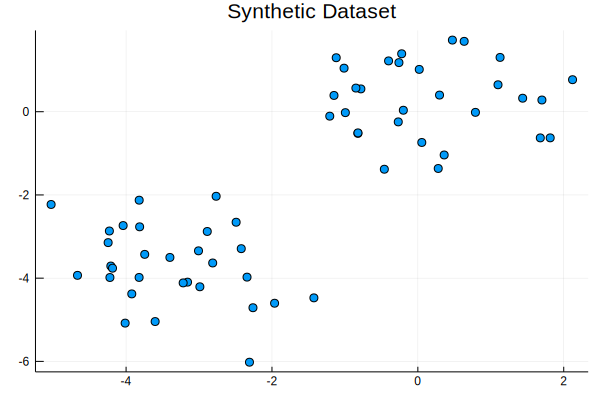

In [1]:
using Distributions, StatsPlots, Random

# Set a random seed.
Random.seed!(3)

# Construct 30 data points for each cluster.
N = 30

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0]

# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], 1.), N), hcat, 1:2)

# Visualization.
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

## Gaussian Mixture Model in Turing

To cluster the data points shown above, we use a model that consists of two mixture components (clusters) and assigns each datum to one of the components. The assignment thereof determines the distribution that the data point is generated from.

In particular, in a Bayesian Gaussian mixture model with $1 \leq k \leq K$ components for 1-D data each data point $x_i$ with $1 \leq i \leq N$ is generated according to the following generative process.
First we draw the parameters for each cluster, i.e. in our example we draw location of the distributions from a Normal:
$$
\mu_k \sim Normal() \, , \;  \forall k \\
$$
and then draw mixing weight for the $K$ clusters from a Dirichlet distribution, i.e.
$$
    w \sim Dirichlet(K, \alpha) \, . \\
$$
After having constructed all the necessary model parameters, we can generate an observation by first selecting one of the clusters and then drawing the datum accordingly, i.e.
$$
    z_i \sim Categorical(w) \, , \;  \forall i \\
    x_i \sim Normal(\mu_{z_i}, 1.) \, , \;  \forall i
$$

For more details on Gaussian mixture models, we refer to Christopher M. Bishop, *Pattern Recognition and Machine Learning*, Section 9.

In [2]:
using Turing, MCMCChains

# Turn off the progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/cameron/.julia/dev/Turing/src/Turing.jl:23


false

In [3]:
@model GaussianMixtureModel(x) = begin
    
    D, N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()
    
    # Draw the parameters for cluster 2.
    μ2 ~ Normal()
    
    μ = [μ1, μ2]
    
    # Uncomment the following lines to draw the weights for the K clusters 
    # from a Dirichlet distribution.
    
    # α = 1.0
    # w ~ Dirichlet(2, α)
    
    # Comment out this line if you instead want to draw the weights.
    w = [0.5, 0.5]
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 2 methods)

After having specified the model in Turing, we can construct the model function and run a MCMC simulation to obtain assignments of the data points.

In [4]:
gmm_model = GaussianMixtureModel(x);

To draw observations from the posterior distribution, we use a [particle Gibbs](https://www.stats.ox.ac.uk/~doucet/andrieu_doucet_holenstein_PMCMC.pdf) sampler to draw the discrete assignment parameters as well as a Hamiltonion Monte Carlo sampler for continous parameters.

Note that we use a `Gibbs` sampler to combine both samplers for Bayesian inference in our model. We are also calling `mapreduce` to generate multiple chains, particularly so we test for convergence. The `chainscat` function simply adds multiple chains together.

In [6]:
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1:3);

## Visualize the Density Region of the Mixture Model

After sucessfully doing posterior inference, we can first visualize the trace and density of the parameters of interest.

In particular, in this example we consider the sample values of the location parameter for the two clusters.

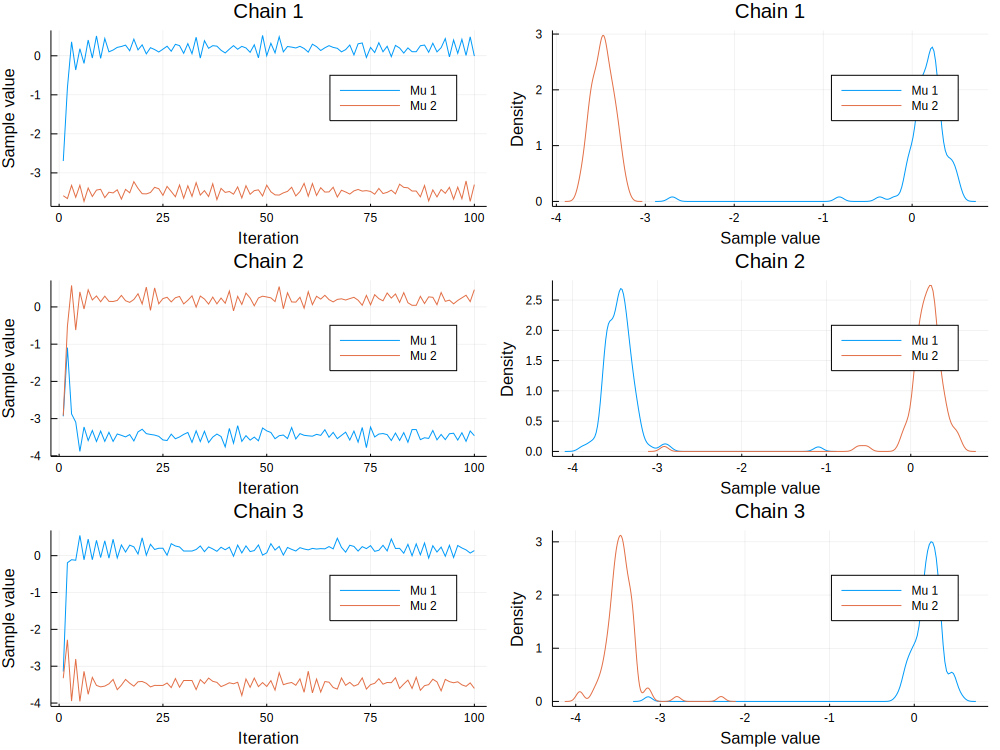

In [7]:
ids = findall(map(name -> occursin("μ", name), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["Mu 1" "Mu 2"], colordim=:parameter)

You'll note here that it appears the location means are switching between chains. We will address this in future tutorials. For those who are keenly interested, see [this](https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html) article on potential solutions.

For the moment, we will just use the first chain to ensure the validity of our inference.

In [8]:
tchain = tchain[:, :, 1];

As the samples for the location parameter for both clusters are unimodal, we can safely visualize the density region of our model using the average location.

In [9]:
# Helper function used for visualizing the density region.
function predict(x, y, w, μ)
    # Use log-sum-exp trick for numeric stability.
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x, y]), 
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x, y])
    )
end

predict (generic function with 1 method)

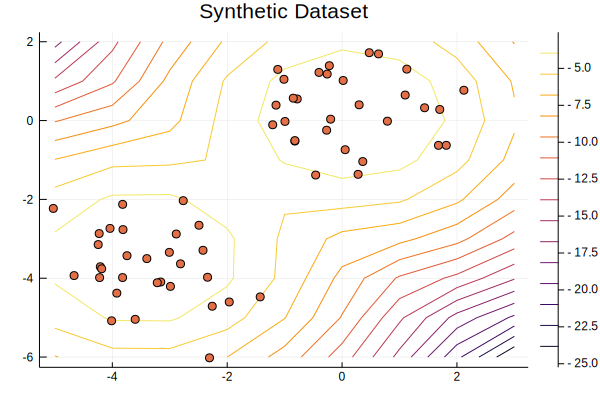

In [10]:
contour(range(-5, stop = 3), range(-6, stop = 2), 
    (x, y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1].value), mean(tchain[:μ2].value)])
)
scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

## Infered Assignments

Finally, we can inspect the assignments of the data points infered using Turing. As we can see, the dataset is partitioned into two distinct groups.

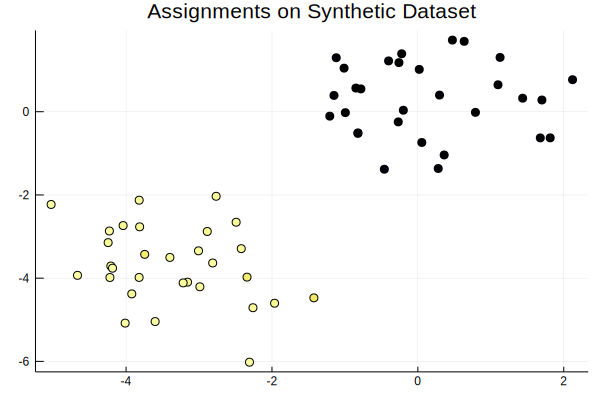

In [11]:
assignments = collect(skipmissing(mean(tchain[:k].value, dims=1).data))
scatter(x[1,:], x[2,:], 
    legend = false, 
    title = "Assignments on Synthetic Dataset", 
    zcolor = assignments)